循环神经网络（Recurrent Neural Networks，RNN）算法是深度学习算法中非常有名的一种算法。RNN之所以称为循环神经网络，是因为一个序列当前的输出与前面的输出有关。具体的表现形式为：网络会对前面的信息进行记忆并应用于当前输出的计算中，即隐藏层之间的节点不再无连接而是有连接的，并且隐藏层的输入不仅包括输入层的输出还包括上一时刻隐藏层的输出。理论上，RNN能够对任何长度的序列数据进行处理。但是在实践中，为了降低复杂性往往假设当前的状态只与前面的几个状态相关。

RNN的独特能力来自于它特殊的结构，x代表输入，h代表输出，输出的一部分会作为输入的一部分重新输入，于是RNN具有了一定的记忆性。

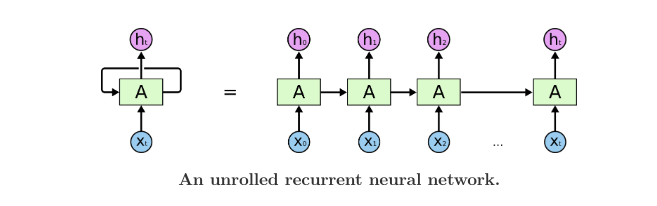

但是生活的经验告诉我们，在比较复杂的情况下，只分析时序数据的最近几个数据是难以得到合理的结果的，需要更长的记忆来追根溯源，于是就有了LSTM（Long Short Term Memory），LSTM可以在更长的时间范围内分析时序数据。

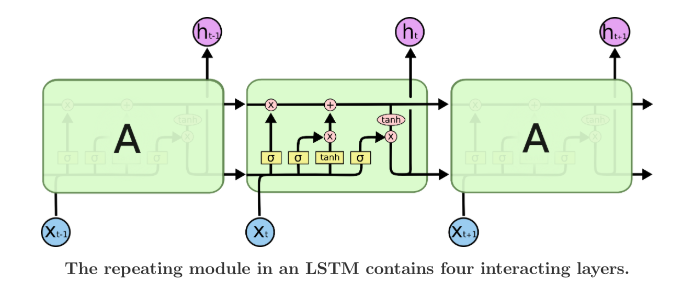

In [1]:
import tflearn
from tflearn.datasets import mnist
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [11]:
X, Y, testX, testY = mnist.load_data(one_hot=True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [12]:
X = X.reshape(-1, 28, 28)
testX = testX.reshape(-1, 28, 28)

In [13]:
net = tflearn.input_data(shape=[None, 28, 28])
net = tflearn.lstm(net, 128, return_seq=True)
net = tflearn.lstm(net, 128)

In [14]:
net = tflearn.fully_connected(net, 10, activation='softmax')

In [15]:
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy', name='output1')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
# 创建神经网络实体
model = tflearn.DNN(net, tensorboard_verbose=2)

In [17]:
model.fit(X, Y, n_epoch=1, validation_set=0.1, show_metric=True, snapshot_step=100)

Training Step: 773  | total loss: 0.25896 | time: 426.972s
| Adam | epoch: 001 | loss: 0.25896 - acc: 0.9257 -- iter: 49472/49500
Training Step: 774  | total loss: 0.25194 | time: 441.524s
| Adam | epoch: 001 | loss: 0.25194 - acc: 0.9285 | val_loss: 0.21686 - val_acc: 0.9367 -- iter: 49500/49500
--


其中主要参数的含义为：

* n_epoch，整个数据集合训练的次数；
* validation_set，验证数据集的比例，也可以直接填写集合，比如（testX，testY），
* show_metric，是否展现完整训练过程，
* snapshot_step，snapshot的训练步长。

识别恶意评论

从早期的BBS到现在的贴吧、微信和微博，恶意评论一直都挥之不去，有的是网友的无意吐槽，有的是水军的恶意攻击。以往大型互联网企业都需要雇佣大量的运营支撑人员，人工进行筛选，随着互联网的发展，尤其是移动互联网的发展，人工维护几乎成了不可能完成的任务。这次我们尝试使用机器学习的方法来识别恶意评论

In [10]:
import glob
import keras
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from keras.layers.core import Dense
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [11]:
def load_data(path, neg=False, pos=True):
    fileList = glob.glob(path + '*.txt')
    positive = []
    negative = []
    count = 0
    if pos:
        for file in fileList:
            posi = []
            f1 = open(file)
            for line in f1.readlines():
                posi.append(line.strip('\n'))
                count += 1
            positive.append(posi)
        return positive, count
    if neg:
        for file in fileList:
            nega = []
            f1 = open(file)
            for line in f1.readlines():
                posi.append(line.strip('\n'))
                count += 1
            negativea.append(nega)
        return negative, count

In [12]:
positive, labelsize1 = load_data('./数据集/movie-review-data/review_polarity/txt_sentoken/pos/')
y1 = [0] * labelsize1
negative, labelsize2 = load_data('./数据集/movie-review-data/review_polarity/txt_sentoken/neg/')
y2 = [1] * labelsize2
sentiment = positive + negative
y = y1 + y2

In [13]:
sentiments = []
for sentences in sentiment:
    for sentence in sentences:
        sentiments.append(sentence)
vp = tf.contrib.learn.preprocessing.VocabularyProcessor(3000)
vp.fit(sentiments)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [14]:
X = np.zeros_like(np.array(sentiments))
X = np.array(list(vp.transform(sentiments)))

In [17]:
X.shape

(64720, 3000)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4)

In [24]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [25]:
gnb.score(X_val, y_val)

0.5172666872682324

In [19]:
trainX = pad_sequences(X_train, maxlen=100)
valX = pad_sequences(X_val, maxlen=100)
trainY = to_categorical(y_train, num_classes=2)
valY = to_categorical(y_val, num_classes=2)

In [20]:
trainX.shape

(38832, 100)

In [27]:
model = Sequential()
model.add(Embedding(input_dim=len(sentiments), output_dim=128))
model.add(LSTM(128, dropout=0.8))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          
model.fit(trainX, trainY, validation_data=(valX, valY), batch_size=1000, epochs=5)

Train on 38832 samples, validate on 25888 samples
Epoch 1/5
38832/38832 [==============================] - 472s 12ms/step - loss: 0.6937 - acc: 0.5035 - val_loss: 0.6930 - val_acc: 0.5110
Epoch 2/5
38832/38832 [==============================] - 415s 11ms/step - loss: 0.6935 - acc: 0.5030 - val_loss: 0.6930 - val_acc: 0.5110
Epoch 3/5
38832/38832 [==============================] - 418s 11ms/step - loss: 0.6934 - acc: 0.5045 - val_loss: 0.6936 - val_acc: 0.4890
Epoch 4/5
38832/38832 [==============================] - 416s 11ms/step - loss: 0.6934 - acc: 0.5031 - val_loss: 0.6931 - val_acc: 0.5110
Epoch 5/5
38832/38832 [==============================] - 435s 11ms/step - loss: 0.6932 - acc: 0.5043 - val_loss: 0.6931 - val_acc: 0.5110


In [28]:
model.evaluate(valX, valY, batch_size=100)

25888/25888 [==============================] - 142s 6ms/step


[0.6930594986076702, 0.5109703315718949]

RNN具有记忆性，在经过大量训练后可以学习到时序数据的潜在规律，并且可以使用这种规律随机生成新的序列。

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('classic')
import warnings
import nltk
import glob
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
FILENAME = './数据集/US_Cities.txt'

def build_vocab(filename):
    counter = Counter()
    f = open(filename, 'r')
    for line in f:
        for c in '_'.join(line.strip()).replace(' ', 'SPACE').split('_'):
            counter[c] += 1
    chr2idx = {c:i+3 for i, c in enumerate(counter)}
    chr2idx['SOS'] = 0
    chr2idx['EOS'] = 1
    chr2idx['UNK'] = 2
    idx2chr = {v:k for k, v in chr2idx.items()}
    return chr2idx, idx2chr

In [4]:
def get_maxlen(filename):
    f = open(filename, 'r')
    sent_len = 0
    sent_maxlen = 0
    for line in f:
        sent_len = len(line.strip()) + 2
        if sent_len > sent_maxlen:
            sent_maxlen = sent_len
    return sent_maxlen

In [5]:
def vectorize(filename, chr2idx, seqlen, step):
    f = open(filename, 'r')
    text = []
    for line in f:
        line = ['SOS'] + '_'.join(line.strip()).replace(' ', 'SPACE').split('_') + ['EOS']
        for word in line:
            text.append(word)
    input_chars = []
    label_chars = []
    for i in range(0, len(text) - seqlen, step):
        input_chars.append(text[i:i + seqlen])
        label_chars.append(text[i + seqlen])
    X = np.zeros((len(input_chars), seqlen, len(chr2idx)))
    y = np.zeros((len(input_chars), len(chr2idx)))
    for i, input_char in enumerate(input_chars):
        for j, char in enumerate(input_char):
            X[i, j, chr2idx[char]] = 1
        y[i, chr2idx[label_chars[i]]] = 1
    return X, y

In [6]:
STEP = 1
SEQLEN = get_maxlen(FILENAME)

chr2idx, idx2chr = build_vocab(FILENAME)
X, y = vectorize(FILENAME, chr2idx, SEQLEN, STEP)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
HIDDEN_SIZE = 128
BATCH_SIZE = 256
NUM_EPOCHS = 10

model = Sequential()
model.add(LSTM(HIDDEN_SIZE, return_sequences=False, input_shape=(SEQLEN, len(chr2idx)), unroll=True))
model.add(Dense(len(chr2idx)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, y_test))

Train on 182071 samples, validate on 45518 samples
Epoch 1/10
182071/182071 [==============================] - 702s 4ms/step - loss: 2.6196 - acc: 0.2818 - val_loss: 2.1920 - val_acc: 0.3590
Epoch 2/10
182071/182071 [==============================] - 635s 3ms/step - loss: 2.0403 - acc: 0.4051 - val_loss: 1.8658 - val_acc: 0.4716
Epoch 3/10
182071/182071 [==============================] - 639s 4ms/step - loss: 1.6745 - acc: 0.5336 - val_loss: 1.5140 - val_acc: 0.5817
Epoch 4/10
182071/182071 [==============================] - 640s 4ms/step - loss: 1.4124 - acc: 0.6096 - val_loss: 1.3553 - val_acc: 0.6262
Epoch 5/10
182071/182071 [==============================] - 612s 3ms/step - loss: 1.2881 - acc: 0.6432 - val_loss: 1.2674 - val_acc: 0.6503
Epoch 6/10
182071/182071 [==============================] - 625s 3ms/step - loss: 1.2125 - acc: 0.6626 - val_loss: 1.2112 - val_acc: 0.6632
Epoch 7/10
182071/182071 [==============================] - 631s 3ms/step - loss: 1.1602 - acc: 0.6753 - val_

In [36]:
model.evaluate(X_test, y_test, verbose=1, batch_size=BATCH_SIZE)

45518/45518 [==============================] - 60s 1ms/step


[1.1071459434222994, 0.690430159534007]

In [37]:
y_pred = model.predict(X_test)

In [38]:
NUM_DISPLAY = 100

sentence = []
sentences = []
idx = []
for i in range(NUM_DISPLAY):
    idx.append(np.argmax(y_pred[i]))
for j in idx:
    sentence.append(idx2chr[j])
sentences.append(' '.join(sentence))
print(sentences)

['EOS o i r SOS EOS C SOS r M e n f e EOS w SOS h O o SPACE EOS y r t EOS t SOS t i y p e R i c c i o n i e n a EOS e SOS SOS y a n a g r l G o y EOS l n v EOS K e EOS o a o a a R e EOS e M SOS o a e a o n n K s l o N r d e EOS EOS SPACE o r l r SOS']


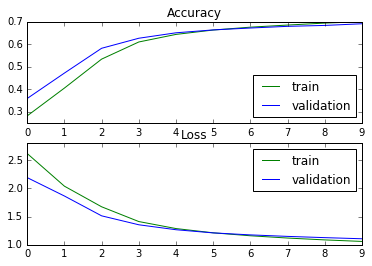

In [39]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

In [40]:
NUM_ITERATIONS = 32
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 10

sentence = ''
test_idx = np.random.randint(len(chr2idx))
test_chars = seed = idx2chr[test_idx]
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" %(iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)
    print("Generating from seed: %s" %(test_chars))
    for i in range(NUM_EPOCHS_PER_ITERATION):
        X_test = np.zeros((1, SEQLEN, len(chr2idx)))
        for j, ch in enumerate(test_chars):
            X_test[0, j, chr2idx[ch]] = 1
        pred = model.predict(X_test, verbose=0)[0]
        ypred = idx2chr[np.argmax(pred)]
        sentence += ypred
        test_chars = ypred
    print(seed + sentence)

Iteration #: 0
Epoch 1/1
227589/227589 [==============================] - 722s 3ms/step - loss: 1.0468 - acc: 0.7031
Generating from seed: -
-e
Iteration #: 1
Epoch 1/1
227589/227589 [==============================] - 700s 3ms/step - loss: 1.0226 - acc: 0.7084
Generating from seed: e
-ee
Iteration #: 2
Epoch 1/1
227589/227589 [==============================] - 728s 3ms/step - loss: 1.0032 - acc: 0.7134
Generating from seed: e
-eee
Iteration #: 3
Epoch 1/1
227589/227589 [==============================] - 701s 3ms/step - loss: 0.9820 - acc: 0.7178
Generating from seed: e
-eeee
Iteration #: 4
Epoch 1/1
227589/227589 [==============================] - 717s 3ms/step - loss: 0.9641 - acc: 0.7223
Generating from seed: e
-eeeeo
Iteration #: 5
Epoch 1/1
227589/227589 [==============================] - 703s 3ms/step - loss: 0.9482 - acc: 0.7256
Generating from seed: o
-eeeeoo
Iteration #: 6
Epoch 1/1
227589/227589 [==============================] - 525s 2ms/step - loss: 0.9334 - acc: 0.7296
Gene

In [41]:
FILENAME = './数据集/Password/wvs-pass.txt'

STEP = 1
SEQLEN = get_maxlen(FILENAME)

chr2idx, idx2chr = build_vocab(FILENAME)
X, y = vectorize(FILENAME, chr2idx, SEQLEN, STEP)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
HIDDEN_SIZE = 128
BATCH_SIZE = 256
NUM_EPOCHS = 10

model = Sequential()
model.add(LSTM(HIDDEN_SIZE, return_sequences=False, input_shape=(SEQLEN, len(chr2idx)), unroll=True))
model.add(Dense(len(chr2idx)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, y_test))

Train on 153650 samples, validate on 38413 samples
Epoch 1/10
153650/153650 [==============================] - 327s 2ms/step - loss: 3.0754 - acc: 0.2522 - val_loss: 2.5881 - val_acc: 0.3402
Epoch 2/10
153650/153650 [==============================] - 280s 2ms/step - loss: 2.4535 - acc: 0.3675 - val_loss: 2.3638 - val_acc: 0.3813
Epoch 3/10
153650/153650 [==============================] - 280s 2ms/step - loss: 2.2971 - acc: 0.3984 - val_loss: 2.2486 - val_acc: 0.4097
Epoch 4/10
153650/153650 [==============================] - 280s 2ms/step - loss: 2.1901 - acc: 0.4248 - val_loss: 2.1546 - val_acc: 0.4360
Epoch 5/10
153650/153650 [==============================] - 285s 2ms/step - loss: 2.0987 - acc: 0.4508 - val_loss: 2.0834 - val_acc: 0.4541
Epoch 6/10
153650/153650 [==============================] - 281s 2ms/step - loss: 2.0205 - acc: 0.4717 - val_loss: 2.0221 - val_acc: 0.4698
Epoch 7/10
153650/153650 [==============================] - 280s 2ms/step - loss: 1.9540 - acc: 0.4882 - val_

In [43]:
NUM_ITERATIONS = 10
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

sentence = ''
test_idx = np.random.randint(len(chr2idx))
test_chars = seed = idx2chr[test_idx]
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" %(iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)
    print("Generating from seed: %s" %(test_chars))
    for i in range(NUM_EPOCHS_PER_ITERATION):
        X_test = np.zeros((1, SEQLEN, len(chr2idx)))
        for j, ch in enumerate(test_chars):
            X_test[0, j, chr2idx[ch]] = 1
        pred = model.predict(X_test, verbose=0)[0]
        ypred = idx2chr[np.argmax(pred)]
        sentence += ypred
        test_chars = ypred
    print(seed + sentence)

Iteration #: 0
Epoch 1/1
192063/192063 [==============================] - 331s 2ms/step - loss: 1.7653 - acc: 0.5364
Generating from seed: SOS
SOS·
Iteration #: 1
Epoch 1/1
192063/192063 [==============================] - 318s 2ms/step - loss: 1.7197 - acc: 0.5477
Generating from seed: ·
SOS·y
Iteration #: 2
Epoch 1/1
192063/192063 [==============================] - 317s 2ms/step - loss: 1.6778 - acc: 0.5582
Generating from seed: y
SOS·yy
Iteration #: 3
Epoch 1/1
192063/192063 [==============================] - 317s 2ms/step - loss: 1.6400 - acc: 0.5677
Generating from seed: y
SOS·yyy
Iteration #: 4
Epoch 1/1
192063/192063 [==============================] - 317s 2ms/step - loss: 1.6039 - acc: 0.5767
Generating from seed: y
SOS·yyy1
Iteration #: 5
Epoch 1/1
192063/192063 [==============================] - 318s 2ms/step - loss: 1.5710 - acc: 0.5850
Generating from seed: 1
SOS·yyy1s
Iteration #: 6
Epoch 1/1
192063/192063 [==============================] - 321s 2ms/step - loss: 1.5407 - ac

192063/192063 [==============================] - 352s 2ms/step - loss: 0.9051 - acc: 0.7558
Generating from seed: 5
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS
Iteration #: 70
Epoch 1/1
192063/192063 [==============================] - 347s 2ms/step - loss: 0.9003 - acc: 0.7567
Generating from seed: EOS
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS4
Iteration #: 71
Epoch 1/1
192063/192063 [==============================] - 349s 2ms/step - loss: 0.8987 - acc: 0.7585
Generating from seed: 4
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS4EOS
Iteration #: 72
Epoch 1/1
192063/192063 [==============================] - 352s 2ms/step - loss: 0.8949 - acc: 0.7594
Generating from seed: EOS
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS4EOSEOS
Iteration #: 73
Epoch 1/1
192063/192063 [==============================] - 349s 2m

192063/192063 [==============================] - 324s 2ms/step - loss: 0.8487 - acc: 0.7698
Generating from seed: #
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS4EOSEOS05uTsEOSFiEOSEOSp7Zq!hEOSSEOS1yEOS#EOS
Iteration #: 97
Epoch 1/1
192063/192063 [==============================] - 329s 2ms/step - loss: 0.8470 - acc: 0.7703
Generating from seed: EOS
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS4EOSEOS05uTsEOSFiEOSEOSp7Zq!hEOSSEOS1yEOS#EOSEOS
Iteration #: 98
Epoch 1/1
192063/192063 [==============================] - 331s 2ms/step - loss: 0.8403 - acc: 0.7730
Generating from seed: EOS
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth55555535357Q7IEOSbw5EOSqEOS589fqh^zyEOS0AEOSzz$5EOS4EOSEOS05uTsEOSFiEOSEOSp7Zq!hEOSSEOS1yEOS#EOSEOSEOS
Iteration #: 99
Epoch 1/1
192063/192063 [==============================] - 330s 2ms/step - loss: 0.8462 - acc: 0.7705
Generating from seed: EOS
SOS·yyy1sdddEOSf-sdhdfqLsyhEOS755dyfth

In [44]:
PATH_NORMAL = './数据集/ADFA-LD/Training_Data_Master/'
PATH_ATTACK = './数据集/ADFA-LD/Attack_Data_Master/Web_Shell_*/'

def build_vocab(path1, path2):
    fileList1 = glob.glob(path1 + '*.txt')
    fileList2 = glob.glob(path2 + '*.txt')
    fileList = fileList1 + fileList2
    counter = Counter()
    for file in fileList:
        f = open(file, 'r')
        for line in f:
            for integer in str(line).strip().split():
                counter[integer] += 1
    int2idx = {integer:i+2 for i, integer in enumerate(counter)}
    int2idx['PAD'] = 0
    int2idx['UNK'] = 1
    idx2int = {v:k for k, v in int2idx.items()}
    return int2idx, idx2int

In [45]:
def get_maxlen(path1, path2):
    sent_len = 0
    sent_maxlen = 0
    fileList1 = glob.glob(path1 + '*.txt')
    fileList2 = glob.glob(path2 + '*.txt')
    fileList = fileList1 + fileList2
    for file in fileList:
        f = open(file, 'r')
        for line in f:
            sent_len = len(str(line).strip())
            if sent_len > sent_maxlen:
                sent_maxlen = sent_len
    return sent_maxlen

In [46]:
def vectorize(path1, path2, int2idx):
    sentences = []
    fileList1 = glob.glob(path1 + '*.txt')
    fileList2 = glob.glob(path2 + '*.txt')
    fileList = fileList1 + fileList2
    i = 0
    j = 0
    for file in fileList:
        f = open(file, 'r')
        for line in f:
            sentence = []
            for integer in str(line).strip().split():
                sentence.append(int2idx[integer])
            sentences.append(sentence)
            if file not in fileList2:
                i += 1
            else:
                j += 1
    X = pad_sequences(sentences, maxlen=get_maxlen(path1, path2))
    Y = to_categorical(i * [0] + j * [1], num_classes=2)
    return X, Y  

In [48]:
int2idx, idx2int = build_vocab(PATH_NORMAL, PATH_ATTACK)
maxlen = get_maxlen(PATH_NORMAL, PATH_ATTACK)
X, Y = vectorize(PATH_NORMAL, PATH_ATTACK, int2idx)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [54]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 256
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(len(int2idx), EMBEDDING_SIZE, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, Y_test))

Train on 760 samples, validate on 191 samples
Epoch 1/10
256/760 [=========>....................] - ETA: 12:41 - loss: 0.6976 - acc: 0.3398

In [ ]:
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

In [4]:
def build_vocab(path):
    fileList = glob.glob(path + 'User*')
    counter = Counter()
    for file in fileList:
        user = []
        f = open(file, 'r')
        for line in f:
            for word in line.strip().split():
                counter[word.lower()] += 1
    word2idx = {w:i+2 for i, w in enumerate(counter.most_common())}
    word2idx['PAD'] = 0
    word2idx['UNK'] = 1
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word

In [5]:
def get_maxlen(path):
    fileList = glob.glob(path + 'User*')
    command_maxlen = 0
    for file in fileList:
        user = []
        f = open(file, 'r')
        for line in f:
            user.append(line.strip())
        command_len = len(user)
        if command_len > command_maxlen:
            command_maxlen = command_len
    return command_maxlen

In [6]:
def vectorize(path, word2idx):
    users = []
    fileList = glob.glob(path + 'User*')
    for file in fileList:
        user = []
        f = open(file, 'r')
        for line in f:
            try:
                user.append(word2idx[line.strip()])
            except KeyError:
                user.append(word2idx['UNK'])                
        users.append(user)
    return pad_sequences(users, maxlen=get_maxlen(path))

In [7]:
def get_label(filename):
    label = np.loadtxt(filename)
    zero = np.zeros((50, label.shape[1]))
    labels = np.concatenate([zero, label])
    mean = labels.mean()
    y = []
    for i in np.sum(labels, axis=0):
        if i > mean:
            y.append(1)
        else:
            y.append(0)
    return y

In [8]:
PATH = './数据集/masquerade/'
FILENAME = './数据集/masquerade/labels.txt'
word2idx, idx2word = build_vocab(PATH)
maxlen = get_maxlen(PATH)
X = vectorize(PATH, word2idx)
Y = to_categorical(get_label(FILENAME), num_classes=2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [9]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 256
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(len(word2idx), EMBEDDING_SIZE, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, Y_test))

Train on 40 samples, validate on 10 samples
Epoch 1/10
40/40 [==============================] - 128s 3s/step - loss: 0.6916 - acc: 0.5250 - val_loss: 0.6980 - val_acc: 0.4000
Epoch 2/10
40/40 [==============================] - 89s 2s/step - loss: 0.6879 - acc: 0.6250 - val_loss: 0.7018 - val_acc: 0.4000
Epoch 3/10
40/40 [==============================] - 79s 2s/step - loss: 0.6844 - acc: 0.6250 - val_loss: 0.7056 - val_acc: 0.4000
Epoch 4/10
40/40 [==============================] - 86s 2s/step - loss: 0.6781 - acc: 0.6250 - val_loss: 0.7099 - val_acc: 0.4000
Epoch 5/10
40/40 [==============================] - 87s 2s/step - loss: 0.6777 - acc: 0.6250 - val_loss: 0.7150 - val_acc: 0.4000
Epoch 6/10
40/40 [==============================] - 86s 2s/step - loss: 0.6745 - acc: 0.6250 - val_loss: 0.7206 - val_acc: 0.4000
Epoch 7/10
40/40 [==============================] - 113s 3s/step - loss: 0.6692 - acc: 0.6250 - val_loss: 0.7274 - val_acc: 0.4000
Epoch 8/10
40/40 [==========================

In [ ]:
model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)